In [1]:
import tensorflow as tf
from tensorflow.keras.layers import  Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
#from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50 

In [2]:
rn50 = ResNet50(input_shape=(256,256, 3),
                        include_top=False, 
                        weights='imagenet')
for layer in rn50.layers:
  layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [3]:
x = GlobalAveragePooling2D()(rn50.output)
x = Dense(1024, activation='relu')(x)
x = Dense(64, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=rn50.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [4]:
train_path = '../input/cassava-train/cassava_train/'
df = pd.read_csv('../input/cassava/train_data.csv')
#df.head()

df.label = df.label.astype('str')

In [5]:
size = 256
batch_size = 64
epochs = 15

In [6]:
traingen = ImageDataGenerator(validation_split=0.15, 
                                      preprocessing_function=preprocess_input,
                                     rotation_range = 15,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)
validgen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)

In [7]:
train_gen = traingen.flow_from_dataframe(df, directory=train_path, 
                                       subset='training',
                                       x_col='image_id',
                                       y_col = "label",
                                       target_size = (size, size),
                                       batch_size = batch_size,
                                       shuffle=True,
                                       class_mode = "sparse")
valid_gen = validgen.flow_from_dataframe(df, directory=train_path, 
                                       subset='validation',
                                       x_col='image_id',
                                       y_col = "label",
                                       target_size = (size, size),
                                       batch_size = batch_size,
                                       shuffle=False,
                                       class_mode = "sparse")

Found 18006 validated image filenames belonging to 5 classes.
Found 3177 validated image filenames belonging to 5 classes.


In [8]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 10, mode = 'min', verbose = 1,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                                      patience = 6, min_delta = 0.001, 
                                      mode = 'min', verbose = 1)

In [9]:
history = {}
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              metrics=['accuracy'])
model_save = ModelCheckpoint('./rn50_transfer_cassava',
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
milestone = model.fit(train_gen,
          validation_data=valid_gen,
          epochs=epochs,
          steps_per_epoch=train_gen.n//train_gen.batch_size,
          validation_steps = valid_gen.n//valid_gen.batch_size,
          callbacks = [model_save, early_stop, reduce_lr]
          )
history['adam'] = milestone


Epoch 1/15
281/281 [==============================] - 713s 3s/step - loss: 1.0789 - accuracy: 0.6348 - val_loss: 0.8063 - val_accuracy: 0.6856

Epoch 00001: val_loss improved from inf to 0.80627, saving model to ./rn50_transfer_cassava
Epoch 2/15
281/281 [==============================] - 483s 2s/step - loss: 0.7360 - accuracy: 0.7271 - val_loss: 0.6981 - val_accuracy: 0.7401

Epoch 00002: val_loss improved from 0.80627 to 0.69812, saving model to ./rn50_transfer_cassava
Epoch 3/15
281/281 [==============================] - 487s 2s/step - loss: 0.6976 - accuracy: 0.7448 - val_loss: 0.7253 - val_accuracy: 0.7388

Epoch 00003: val_loss did not improve from 0.69812
Epoch 4/15
281/281 [==============================] - 500s 2s/step - loss: 0.6703 - accuracy: 0.7536 - val_loss: 0.6797 - val_accuracy: 0.7471

Epoch 00004: val_loss improved from 0.69812 to 0.67966, saving model to ./rn50_transfer_cassava
Epoch 5/15
281/281 [==============================] - 522s 2s/step - loss: 0.6544 - accur

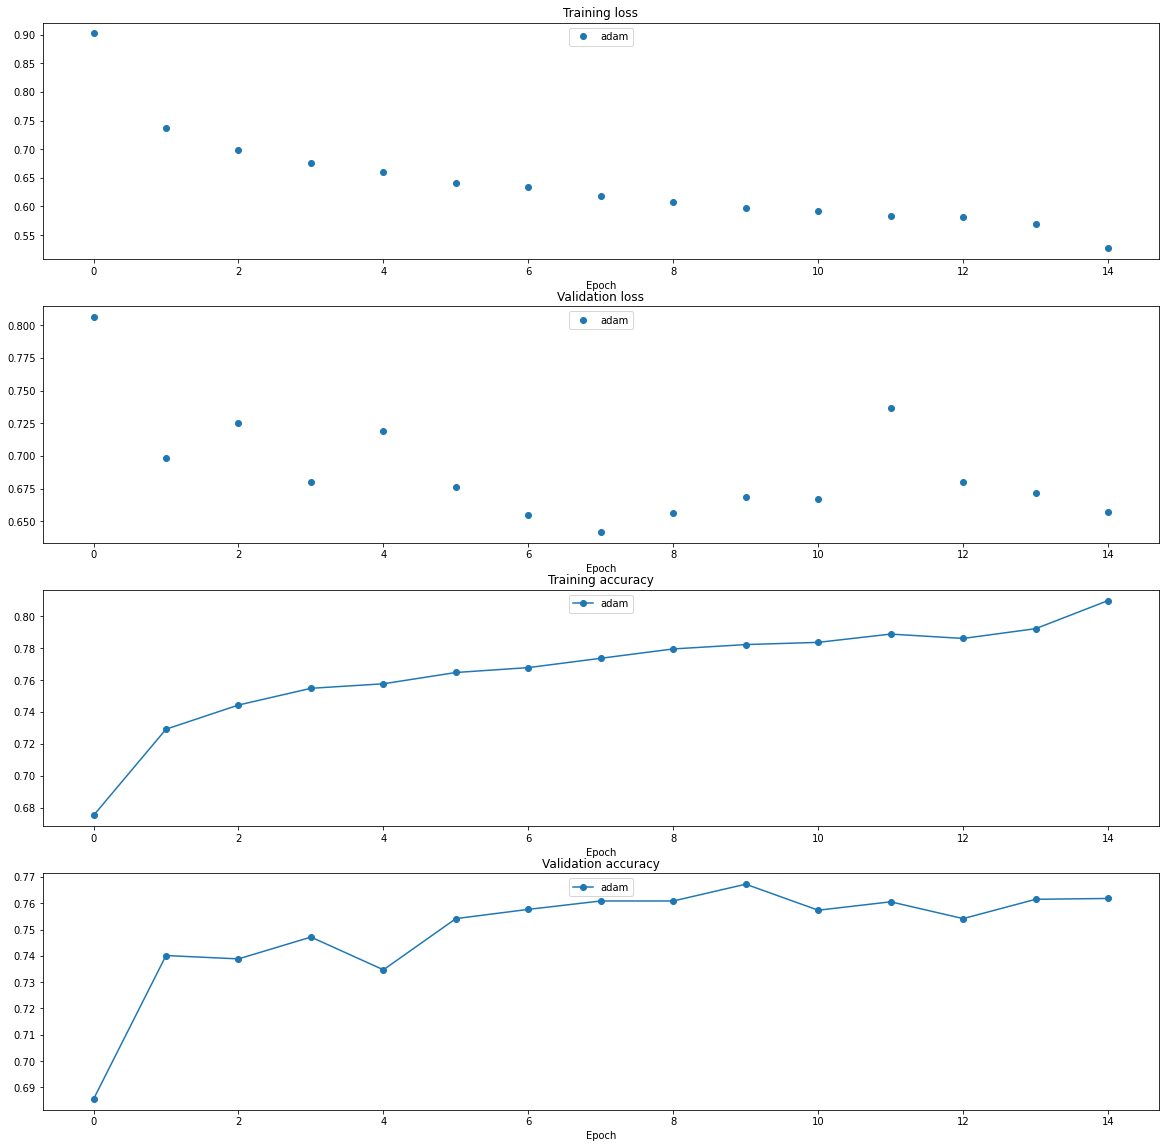

In [10]:
#Drawing
plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, milestone in history.items():
    plt.subplot(4, 1, 1)
    plt.plot(milestone.history['loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 2)
    plt.plot(milestone.history['val_loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 3)
    plt.plot(milestone.history['accuracy'], '-o', label=update_rule)
    
    plt.subplot(4, 1, 4)
    plt.plot(milestone.history['val_accuracy'], '-o', label=update_rule)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(20, 20)
plt.show()